<a href="https://colab.research.google.com/github/norannali/Swarm-Intelligence-for-Maze-Solving-ABC-vs-ACO-vs-PSO/blob/main/Final_Swarm_Intelligence_for_Maze_Solving_ABC_vs_ACO_vs_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from time import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque


In [2]:
import numpy as np
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

def generate_maze(width=20, height=20, obstacle_density=0.25, food_density=0.1):
    """
    Generates a 2D maze with guaranteed path from start (top-left) to goal (bottom-right).

    Parameters:
        width (int): Number of columns in the maze.
        height (int): Number of rows in the maze.
        obstacle_density (float): Probability of placing an obstacle (0 to 1).
        food_density (float): Probability of placing a food pellet (0 to 1).

    Cell values:
        0 = Empty cell
        1 = Obstacle
        2 = Start position (0,0)
        3 = Goal position (height-1, width-1)
        4 = Food pellet
    """
    # Initialize maze grid with empty cells
    maze = np.zeros((height, width), dtype=int)

    # Create a guaranteed path from (0,0) to (height-1, width-1)
    x, y = 0, 0
    path = [(x, y)]
    while x < height - 1 or y < width - 1:
        if x == height - 1:
            y += 1
        elif y == width - 1:
            x += 1
        else:
            if random.random() < 0.5:
                x += 1
            else:
                y += 1
        path.append((x, y))

    # Mark the path as safe (no obstacles)
    for i in range(height):
        for j in range(width):
            if (i, j) in path:
                maze[i][j] = 0  # Ensure path remains clear

    # Place obstacles randomly (but not on the path)
    for i in range(height):
        for j in range(width):
            if (i, j) not in path and random.random() < obstacle_density:
                maze[i][j] = 1

    # Place food pellets (not at start, first move, or goal)
    for i in range(height):
        for j in range(width):
            if maze[i][j] == 0 and (i, j) not in path[:2] and (i, j) != path[-1]:
                if random.random() < food_density:
                    maze[i][j] = 4  # Food pellet

    # Mark start and goal positions
    maze[0][0] = 2  # Start
    maze[height - 1][width - 1] = 3  # Goal

    return maze

In [21]:
def visualize_maze(maze):
    height, width = maze.shape
    color_map = {
    0: "#D3D3D3",  # Empty
    1: "#404040",  # Obstacle
    2: "#00FF00",  # Start
    3: "#FF0000",  # Goal
    4: "#e07a5f",  # Food
}
    fig, ax = plt.subplots()
    for i in range(height):
        for j in range(width):
            value = maze[i, j]
            color = color_map.get(value, "#FFFFFF")
            ax.add_patch(plt.Rectangle((j, height - i - 1), 1, 1, color=color))
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks([])
    plt.yticks([])

    # Legend
    legend_patches = [
        mpatches.Patch(color=color_map[2], label='Start'),
        mpatches.Patch(color=color_map[3], label='Goal'),
        mpatches.Patch(color=color_map[0], label='Empty'),
        mpatches.Patch(color=color_map[1], label='Obstacle'),
        mpatches.Patch(color=color_map[4], label='Food')
    ]
    plt.legend(handles=legend_patches, loc='upper right')
    plt.title("Maze with Food Pellets")
    plt.show()

In [22]:
import matplotlib.patches as mpatches # Import the patches module

def plot_solution(maze, path, algorithm_name="Ant Colony Optimization"):
    if not path or path[-1] != get_start_goal(maze)[1]:
        print("No valid path found.")
        # Call visualize_maze with plt imported, if it's defined globally or imported elsewhere
        # If visualize_maze is used later, ensure it's defined before this function call
        visualize_maze(maze)
        return

    height, width = maze.shape
    color_map = {
        0: "#D3D3D3",  # Empty
        1: "#404040",  # Obstacle
        2: "#00FF00",  # Start
        3: "#FF0000",  # Goal
        4: "#e07a5f",  # Food
    }

    fig, ax = plt.subplots()
    for i in range(height):
        for j in range(width):
            value = maze[i, j]
            color = color_map.get(value, "#FFFFFF")
            # Use mpatches.Rectangle instead of just Rectangle
            ax.add_patch(mpatches.Rectangle((j, height - i - 1), 1, 1, color=color))

    # Highlight collected food
    collected_food = [cell for cell in path if maze[cell] == 4]
    for (x, y) in collected_food:
        # Use mpatches.Rectangle instead of just Rectangle
        ax.add_patch(mpatches.Rectangle((y, height - x - 1), 1, 1, color="#A0A0A0"))  # Gray out collected food

    # Draw path
    for (x, y) in path:
        # Use mpatches.Circle instead of just Circle
        ax.add_patch(mpatches.Circle((y + 0.5, height - x - 0.5), 0.2, color="blue"))

    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks([])
    plt.yticks([])
    num_points = len(path)
    food_collected = len(collected_food)
    # Ensure np is imported for np.sum if used
    total_food = np.sum(maze == 4)
    plt.title(f"{algorithm_name}\nPath Length: {num_points}, Food Collected: {food_collected}/{total_food}")
    plt.show()

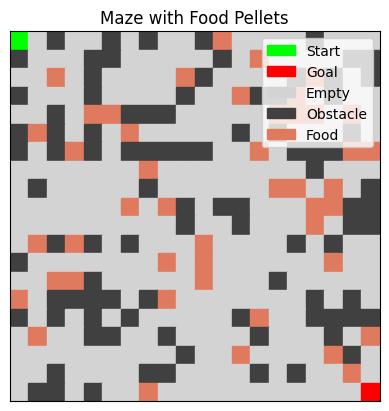

In [23]:
maze = generate_maze(width=20, height=20, obstacle_density=0.25)
visualize_maze(maze)

In [24]:
#Common functions for all algorithms
def get_start_goal(maze):
    start, goal = None, None
    for i in range(len(maze)):
        for j in range(len(maze[0])):
            if maze[i][j] == 2:
                start = (i, j)
            elif maze[i][j] == 3:
                goal = (i, j)
    return start, goal

def is_valid_move(maze, pos):
    x, y = pos
    if 0 <= x < len(maze) and 0 <= y < len(maze[0]):
        return maze[x][y] != 1  # Not an obstacle
    return False

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(pos, maze):
    x, y = pos
    neighbors = []
    for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:  # Right, Down, Left, Up
        new_pos = (x + dx, y + dy)
        if is_valid_move(maze, new_pos):
            neighbors.append(new_pos)
    return neighbors
def _heuristic(self, pos):
    base_heuristic = 1 / (manhattan_distance(pos, self.goal) + 1)
    if self.maze[pos] == 4:  # Food cell
        base_heuristic *= 2  # Encourage visiting food
    return base_heuristic

In [25]:
import random
from collections import deque
from IPython.display import clear_output

class ABCMazeSolver:
    def __init__(self, maze, num_bees=30, max_iter=100):
        self.maze = maze
        self.start, self.goal = get_start_goal(maze)
        self.num_bees = num_bees
        self.max_iter = max_iter
        self.population = []
        self.fitness = []
        self.best_solution = None
        self.best_fitness = float('inf')  # Lower is better
        self.food_positions = [(i, j) for i in range(maze.shape[0]) for j in range(maze.shape[1]) if maze[i, j] == 4]

    @staticmethod
    def bfs_path(maze, start, goal):
        queue = deque([[start]])
        visited = set([start])

        while queue:
            path = queue.popleft()
            current = path[-1]
            if current == goal:
                return path
            for neighbor in get_neighbors(current, maze):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(path + [neighbor])
        return None

    def initialize_bees(self):
        base_path = ABCMazeSolver.bfs_path(self.maze, self.start, self.goal)
        if not base_path:
            print("No path found from start to goal even with BFS.")
            return
        for _ in range(self.num_bees):
            self.population.append(base_path)
            self.fitness.append(self._calculate_fitness(base_path))
        self.best_solution = base_path
        self.best_fitness = self.fitness[0]

    def mutate_path(self, path):
        if len(path) <= 2:
            return path
        for _ in range(3):  # Try up to 3 times to find a shortcut
            i = random.randint(1, len(path) - 3)
            j = random.randint(i + 1, len(path) - 2)
            sub_start = path[i]
            sub_goal = path[j]
            temp_path = [sub_start]
            visited = set(temp_path)
            current = sub_start
            while current != sub_goal:
                neighbors = get_neighbors(current, self.maze)
                neighbors = [n for n in neighbors if n not in visited]
                if not neighbors:
                    break
                current = min(neighbors, key=lambda p: manhattan_distance(p, sub_goal))
                temp_path.append(current)
                visited.add(current)
            if current == sub_goal:
                new_path = path[:i] + temp_path + path[j+1:]
                return new_path
        return path  # fallback if no shortcut works

    def _calculate_fitness(self, path):
        if not path or path[-1] != self.goal:
            return float('inf')
        length_score = len(path)
        food_collected = sum(1 for cell in path if self.maze[cell] == 4)
        food_bonus = -food_collected * 0.5  # Bonus per food item
        return length_score + food_bonus

    def optimize(self):
        self.initialize_bees()
        if not self.population:
            print("Failed to find any initial paths to goal.")
            return None
        for iteration in range(self.max_iter):
            new_population = []
            new_fitness = []
            for path in self.population:
                new_path = self.mutate_path(path)
                if new_path[-1] == self.goal:
                    fitness_val = self._calculate_fitness(new_path)
                    new_population.append(new_path)
                    new_fitness.append(fitness_val)
                    if fitness_val < self.best_fitness:
                        self.best_fitness = fitness_val
                        self.best_solution = new_path
            if new_population:
                self.population = new_population
                self.fitness = new_fitness
            clear_output(wait=True)
            print(f"Iteration {iteration+1}/{self.max_iter} | Best Path Length: {len(self.best_solution)} | Food Collected: {-2 * (self._calculate_fitness(self.best_solution) - len(self.best_solution))}")
        return self.best_solution

Iteration 100/100 | Best Path Length: 39 | Food Collected: 7.0


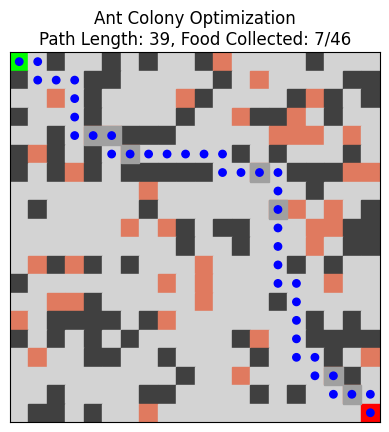

In [26]:
abc_solver = ABCMazeSolver(maze, num_bees=30, max_iter=100)
solution = abc_solver.optimize()
plot_solution(maze, solution)

In [27]:
import random
import numpy as np
from collections import deque
from IPython.display import clear_output
import time # Import time for potential convergence data

class ACOMazeSolver:
    def __init__(self, maze, num_ants=30, alpha=1, beta=3, evaporation_rate=0.5, Q=100, max_iter=100):
        self.maze = maze
        self.start, self.goal = get_start_goal(maze)
        self.num_ants = num_ants
        self.alpha = alpha  # pheromone influence
        self.beta = beta    # heuristic influence
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.max_iter = max_iter
        self.pheromone = np.ones_like(maze, dtype=float)
        self.best_path = None
        self.best_length = float('inf')
        self.convergence_data = [] # Attribute to store best path length per iteration

    def _heuristic(self, pos):
        # Add a small epsilon to avoid division by zero if pos is the goal
        return 1 / (manhattan_distance(pos, self.goal) + 1e-6)

    def _construct_path(self):
        path = [self.start]
        visited = set([self.start])
        current = self.start

        # Limit path length to prevent infinite loops in difficult mazes
        max_path_length = len(self.maze) * len(self.maze[0]) * 2 # A reasonable upper bound

        while current != self.goal and len(path) < max_path_length:
            neighbors = get_neighbors(current, self.maze)
            neighbors = [n for n in neighbors if n not in visited] # Avoid cycles for simplicity

            if not neighbors:
                return None # Dead end

            probs = []
            for n in neighbors:
                # Ensure pheromone values are not negative or zero
                tau = max(1e-6, self.pheromone[n])
                eta = self._heuristic(n)
                probs.append((tau ** self.alpha) * (eta ** self.beta))

            total = sum(probs)
            if total == 0:
                # If all neighbor probabilities are zero (e.g., due to zero pheromone),
                # choose a random valid neighbor if available.
                valid_neighbors = get_neighbors(current, self.maze)
                if not valid_neighbors: return None # Truly stuck
                next_cell = random.choice(valid_neighbors)
            else:
                probs = [p / total for p in probs]
                # Use try-except to handle potential ValueError if weights don't sum to 1
                try:
                    next_cell = random.choices(neighbors, weights=probs, k=1)[0]
                except ValueError:
                     # Fallback to random choice among valid neighbors if weights issue
                    valid_neighbors = get_neighbors(current, self.maze)
                    if not valid_neighbors: return None
                    next_cell = random.choice(valid_neighbors)

            path.append(next_cell)
            visited.add(next_cell)
            current = next_cell

        # Check if the generated path actually reached the goal
        if path and path[-1] == self.goal:
             return path
        else:
             return None


    def _update_pheromones(self, all_paths):
        # Evaporate pheromones
        self.pheromone *= (1 - self.evaporation_rate)

        # Deposit pheromones
        for path in all_paths:
            if path: # Only deposit pheromone if a valid path was found
                length = len(path)
                if length > 0: # Avoid division by zero
                    pheromone_deposit = self.Q / length
                    for cell in path:
                        self.pheromone[cell] += pheromone_deposit


    def optimize(self):
      self.convergence_data = [] # Reset convergence data at the start of optimization
      for iteration in range(self.max_iter):
          all_paths = []
          # Construct paths for each ant
          for _ in range(self.num_ants):
              path = self._construct_path()
              if path: # Only consider valid paths that reach the goal
                 all_paths.append(path)
                 # Update the overall best path found
                 if len(path) < self.best_length:
                     self.best_length = len(path)
                     self.best_path = path

          # Update pheromones based on the paths constructed in this iteration
          self._update_pheromones(all_paths)

          # Record the best path length for convergence plotting
          # If no valid path was found in this iteration, use the previous best or infinity
          self.convergence_data.append(self.best_length if self.best_path else float('inf'))

          clear_output(wait=True)
          # Print the current best path length, handling the case where no path is found yet
          current_best_length_display = self.best_length if self.best_path else 'N/A'
          print(f"Iteration {iteration+1}/{self.max_iter} | Best Path Length: {current_best_length_display}")

      # Return the best path found across all iterations
      return self.best_path

In [28]:
aco_solver = ACOMazeSolver(maze)
best_path = aco_solver.optimize()

if best_path:
    print("Best path found:", best_path)
else:
    print("No valid path found.")

Iteration 100/100 | Best Path Length: 39
Best path found: [(0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (3, 2), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (10, 7), (11, 7), (12, 7), (13, 7), (13, 8), (14, 8), (14, 9), (15, 9), (15, 10), (16, 10), (17, 10), (18, 10), (18, 11), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (19, 16), (19, 17), (19, 18), (19, 19)]


Iteration 100/100 | Best Path Length: 39


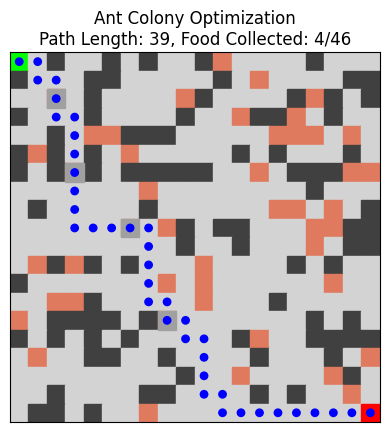

In [29]:
# After running ACO
aco_path = aco_solver.optimize()
plot_solution(maze, aco_path, algorithm_name="Ant Colony Optimization")

In [30]:
class PSOMazeSolver:
    def __init__(self, maze, num_particles=30, w=0.5, c1=1, c2=2, max_iter=100):
        self.maze = maze
        self.start, self.goal = get_start_goal(maze)
        self.num_particles = num_particles
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter
        self.particles = []
        self.velocities = []
        self.pbest_positions = []
        self.pbest_scores = []
        self.gbest_position = None
        self.gbest_score = float('inf')
        self.pheromone = np.zeros_like(maze, dtype=float)

    def _initialize_particles(self):
        for _ in range(self.num_particles):
            path = self._generate_random_path()
            if not path or path[-1] != self.goal:
                path = self._find_path_bfs(self.start, self.goal) or [self.start, self.goal]
            self.particles.append(path)
            self.velocities.append([(0,0)] * len(path))
            score = self._calculate_fitness(path)
            self.pbest_positions.append(path.copy())
            self.pbest_scores.append(score)
            if score < self.gbest_score:
                self.gbest_score = score
                self.gbest_position = path.copy()

    def _generate_random_path(self):
        path = [self.start]
        current = self.start
        visited = set([current])
        max_steps = 2 * (len(self.maze) + len(self.maze[0]))
        for _ in range(max_steps):
            if current == self.goal: break
            neighbors = get_neighbors(current, self.maze)
            neighbors = [n for n in neighbors if n not in visited]
            if not neighbors: break
            next_cell = random.choice(neighbors)
            path.append(next_cell)
            visited.add(next_cell)
            current = next_cell
        return path

    def _find_path_bfs(self, start, goal):
        queue = deque([[start]])
        visited = set([start])
        while queue:
            path = queue.popleft()
            current = path[-1]
            if current == goal: return path
            for neighbor in get_neighbors(current, self.maze):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(path + [neighbor])
        return None

    def _calculate_fitness(self, path):
        if not path or path[-1] != self.goal: return float('inf')
        length_score = len(path)
        obstacle_penalty = sum(1 for cell in path if self.maze[cell] == 1)
        turn_penalty = 0
        if len(path) > 2:
            for i in range(1, len(path)-1):
                prev_dir = (path[i][0]-path[i-1][0], path[i][1]-path[i-1][1])
                next_dir = (path[i+1][0]-path[i][0], path[i+1][1]-path[i][1])
                if prev_dir != next_dir: turn_penalty += 0.1
        return length_score + 10*obstacle_penalty + turn_penalty

    def _update_velocity(self, particle_idx):
        if particle_idx >= len(self.particles): return
        particle = self.particles[particle_idx]
        new_velocity = []
        for i in range(min(len(particle), len(self.pbest_positions[particle_idx]), len(self.gbest_position))):
            pos = particle[i]
            pbest_pos = self.pbest_positions[particle_idx][i] if i < len(self.pbest_positions[particle_idx]) else pos
            gbest_pos = self.gbest_position[i] if i < len(self.gbest_position) else pos
            vel = self.velocities[particle_idx][i] if i < len(self.velocities[particle_idx]) else (0,0)
            r1, r2 = random.random(), random.random()
            new_vel_x = (self.w * vel[0] + self.c1 * r1 * (pbest_pos[0] - pos[0]) + self.c2 * r2 * (gbest_pos[0] - pos[0]))
            new_vel_y = (self.w * vel[1] + self.c1 * r1 * (pbest_pos[1] - pos[1]) + self.c2 * r2 * (gbest_pos[1] - pos[1]))
            max_vel = 2
            new_vel_x = max(-max_vel, min(max_vel, new_vel_x))
            new_vel_y = max(-max_vel, min(max_vel, new_vel_y))
            new_velocity.append((new_vel_x, new_vel_y))
        self.velocities[particle_idx] = new_velocity

    def _update_position(self, particle_idx):
        if particle_idx >= len(self.particles): return
        old_path = self.particles[particle_idx]
        new_path = [self.start]
        for i in range(1, len(old_path)):
            vel_x, vel_y = self.velocities[particle_idx][i-1] if (i-1) < len(self.velocities[particle_idx]) else (0,0)
            new_x = round(old_path[i][0] + vel_x)
            new_y = round(old_path[i][1] + vel_y)
            new_pos = (new_x, new_y)
            if is_valid_move(self.maze, new_pos) and new_pos not in new_path:
                new_path.append(new_pos)
            else:
                neighbors = get_neighbors(old_path[i], self.maze)
                valid_neighbors = [n for n in neighbors if n not in new_path]
                if valid_neighbors: new_path.append(random.choice(valid_neighbors))
                else: new_path.append(old_path[i])
        if new_path[-1] != self.goal and self.goal not in new_path:
            last_pos = new_path[-1]
            path_to_goal = self._find_path_bfs(last_pos, self.goal)
            if path_to_goal: new_path.extend(path_to_goal[1:])
        self.particles[particle_idx] = new_path
        current_score = self._calculate_fitness(new_path)
        if current_score < self.pbest_scores[particle_idx]:
            self.pbest_positions[particle_idx] = new_path.copy()
            self.pbest_scores[particle_idx] = current_score
            if current_score < self.gbest_score:
                self.gbest_score = current_score
                self.gbest_position = new_path.copy()

    def _update_pheromone_trail(self):
        self.pheromone *= 0.9
        if self.gbest_position:
            for cell in self.gbest_position:
                self.pheromone[cell] += 1
    def _calculate_fitness(self, path):
      if not path or path[-1] != self.goal: return float('inf')
      length_score = len(path)
      food_collected = sum(1 for cell in path if self.maze[cell] == 4)
      food_bonus = -food_collected * 0.5  # Bonus per food collected
      return length_score + food_bonus

    def optimize(self):
        self._initialize_particles()
        for iteration in range(self.max_iter):
            try:
                for i in range(len(self.particles)):
                    self._update_velocity(i)
                    self._update_position(i)
                self._update_pheromone_trail()
                clear_output(wait=True)
                current_best = len(self.gbest_position) if self.gbest_position else 'N/A'
                print(f"Iteration {iteration+1}/{self.max_iter} | Best Path Length: {current_best}")
            except Exception as e:
                print(f"Error in iteration {iteration+1}: {str(e)}")
                continue
        return self.gbest_position

In [31]:
# Create the PSO solver object and run the algorithm
pso_solver = PSOMazeSolver(maze, num_particles=20, max_iter=50)
pso_path = pso_solver.optimize()

Iteration 50/50 | Best Path Length: 39


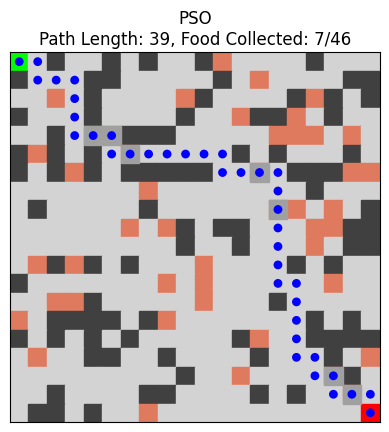

In [32]:
plot_solution(maze, pso_path, algorithm_name="PSO")

Iteration 100/100 | Best Path Length: 39


Comparison Results:
Algorithm       Path Length     Time           
---------------------------------------------
ABC             39              0.5451
ACO             39              1.3674
PSO             39              0.8531


<Figure size 1800x500 with 0 Axes>

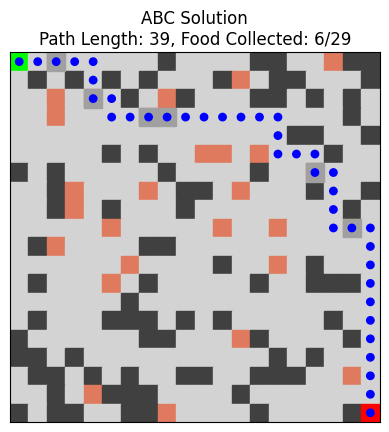

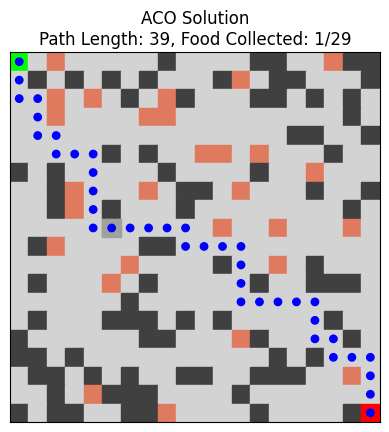

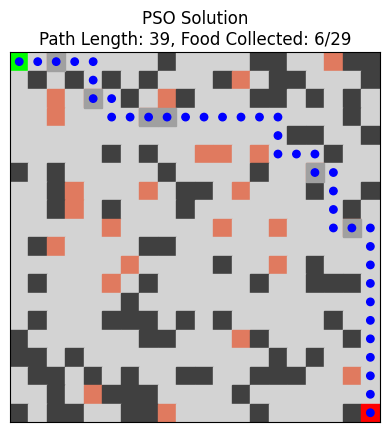

<Figure size 640x480 with 0 Axes>

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

def compare_algorithms(maze, num_agents=30, max_iter=100):
    """
    Compare the performance of ABC, ACO, and PSO algorithms on the same maze.

    Parameters:
        maze: The maze matrix
        num_agents: Number of agents (bees, ants, particles) for each algorithm
        max_iter: Maximum number of iterations per algorithm
    """

    # Dictionary to store results for each algorithm
    results = {
        'ABC': {'time': 0, 'length': 0, 'convergence': []},
        'ACO': {'time': 0, 'length': 0, 'convergence': []},
        'PSO': {'time': 0, 'length': 0, 'convergence': []}
    }

    # Run ABC Algorithm
    print("Running ABC Algorithm...")
    start_time = time.time()
    abc_solver = ABCMazeSolver(maze, num_bees=num_agents, max_iter=max_iter)
    abc_path = abc_solver.optimize()
    results['ABC']['time'] = time.time() - start_time
    results['ABC']['length'] = len(abc_path) if abc_path else float('inf')
    results['ABC']['convergence'] = abc_solver.best_fitness

    # Run ACO Algorithm
    print("\nRunning ACO Algorithm...")
    start_time = time.time()
    aco_solver = ACOMazeSolver(maze, num_ants=num_agents, max_iter=max_iter)
    aco_path = aco_solver.optimize()
    results['ACO']['time'] = time.time() - start_time
    results['ACO']['length'] = len(aco_path) if aco_path else float('inf')
    results['ACO']['convergence'] = aco_solver.best_length

    # Run PSO Algorithm
    print("\nRunning PSO Algorithm...")
    start_time = time.time()
    pso_solver = PSOMazeSolver(maze, num_particles=num_agents, max_iter=max_iter)
    pso_path = pso_solver.optimize()
    results['PSO']['time'] = time.time() - start_time
    results['PSO']['length'] = len(pso_path) if pso_path else float('inf')
    results['PSO']['convergence'] = pso_solver.gbest_score

    # Print comparison results
    print("\n\nComparison Results:")
    print(f"{'Algorithm':<15} {'Path Length':<15} {'Time':<15}")
    print("-"*45)
    for algo in results:
        print(f"{algo:<15} {results[algo]['length']:<15} {results[algo]['time']:.4f}")

    # Visualize paths for each algorithm
    plt.figure(figsize=(18, 5))

    if abc_path:
        plot_solution(maze, abc_path, "ABC Solution")
    else:
        visualize_maze(maze)
        plt.title("ABC - No Path Found")

    if aco_path:
        plot_solution(maze, aco_path, "ACO Solution")
    else:
        visualize_maze(maze)
        plt.title("ACO - No Path Found")

    if pso_path:
        plot_solution(maze, pso_path, "PSO Solution")
    else:
        visualize_maze(maze)
        plt.title("PSO - No Path Found")

    plt.tight_layout()
    plt.show()

    return results

# Generate a new maze
new_maze = generate_maze(width=20, height=20, obstacle_density=0.25)
visualize_maze(new_maze)

# Compare the algorithms on the generated maze
comparison_results = compare_algorithms(new_maze, num_agents=30, max_iter=100)

In [34]:
def multi_run_comparison(maze, num_runs=10):
    """
    Run ABC, ACO, and PSO algorithms multiple times on the same maze.
    Returns statistics like average time, success rate, and average path length.
    """
    results = {
        'ABC': {'times': [], 'lengths': []},
        'ACO': {'times': [], 'lengths': []},
        'PSO': {'times': [], 'lengths': []}
    }

    for run in range(num_runs):
        print(f"\nRun {run + 1}/{num_runs}")

        # ABC Run
        print("Running ABC...")
        start_time = time.time()
        abc_solver = ABCMazeSolver(maze, num_bees=30, max_iter=100)
        abc_path = abc_solver.optimize()
        abc_time = time.time() - start_time
        results['ABC']['times'].append(abc_time)
        if abc_path:
            results['ABC']['lengths'].append(len(abc_path))
        print(f"ABC Path Length: {len(abc_path) if abc_path else 'N/A'} | Time: {abc_time:.4f}s")

        # ACO Run
        print("Running ACO...")
        start_time = time.time()
        aco_solver = ACOMazeSolver(maze, num_ants=30, max_iter=100)
        aco_path = aco_solver.optimize()
        aco_time = time.time() - start_time
        results['ACO']['times'].append(aco_time)
        if aco_path:
            results['ACO']['lengths'].append(len(aco_path))
        print(f"ACO Path Length: {len(aco_path) if aco_path else 'N/A'} | Time: {aco_time:.4f}s")

        # PSO Run
        print("Running PSO...")
        start_time = time.time()
        pso_solver = PSOMazeSolver(maze, num_particles=30, max_iter=100)
        pso_path = pso_solver.optimize()
        pso_time = time.time() - start_time
        results['PSO']['times'].append(pso_time)
        if pso_path:
            results['PSO']['lengths'].append(len(pso_path))
        print(f"PSO Path Length: {len(pso_path) if pso_path else 'N/A'} | Time: {pso_time:.4f}s")

    # Compute stats
    stats = {}
    for algo in results:
        times = results[algo]['times']
        lengths = results[algo]['lengths']
        valid_lengths = [l for l in lengths if l != float('inf')]
        success_rate = len(valid_lengths) / num_runs
        avg_time = np.mean(times)
        avg_len = np.mean(valid_lengths) if valid_lengths else float('inf')
        std_len = np.std(valid_lengths) if valid_lengths else 0
        stats[algo] = {
            'avg_time': avg_time,
            'success_rate': success_rate,
            'avg_length': avg_len,
            'std_length': std_len
        }

    # Print final summary
    print("\n📊 Multi-run Comparison Results:")
    print(f"{'Algorithm':<10} | {'Avg Time':<10} | {'Success Rate':<12} | {'Avg Path Len':<12} | {'Std Dev'}")
    print("-" * 65)
    for algo, data in stats.items():
        print(f"{algo:<10} | {data['avg_time']:<10.4f} | {data['success_rate']*100:<11.2f}% | {data['avg_length']:<12.2f} | {data['std_length']:.2f}")

    return stats

In [35]:
stats = multi_run_comparison(maze, num_runs=5)

Iteration 100/100 | Best Path Length: 39
PSO Path Length: 39 | Time: 1.1497s

📊 Multi-run Comparison Results:
Algorithm  | Avg Time   | Success Rate | Avg Path Len | Std Dev
-----------------------------------------------------------------
ABC        | 0.6951     | 100.00     % | 39.00        | 0.00
ACO        | 1.7193     | 100.00     % | 39.00        | 0.00
PSO        | 1.1113     | 100.00     % | 39.00        | 0.00
